## Carga y visualización de señales de audio

Visualizing sound means to visualize air waves.

We can take samples of the air pressure over time commonly 44.1kHz.

Para la base de datos: https://www.kaggle.com/vbookshelf/respiratory-sound-database

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/Shareddrives/biosenales_sistemas/analisis_audio_ejemplo_proyecto4/example_data.zip .

In [ ]:
!cp /content/drive/Shareddrives/biosenales_sistemas/filtrado/linearFIR.py .

In [ ]:
!unzip /content/example_data.zip

Archive:  /content/example_data.zip
  inflating: example_data/101_1b1_Pr_sc_Meditron.txt  
  inflating: example_data/101_1b1_Al_sc_Meditron.txt  
  inflating: example_data/101_1b1_Pr_sc_Meditron.wav  
  inflating: example_data/101_1b1_Al_sc_Meditron.wav  


In [ ]:
import librosa
import pywt
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

filename = '/content/example_data/101_1b1_Pr_sc_Meditron.wav'
#y, sr = librosa.load(filename, sr = None) #None loads the sampling rate from the wav file
y, sr = librosa.load(filename) #signal and sampling rate

print(type(y))
print(type(sr))
print(y.shape)
print(sr)

<class 'numpy.ndarray'>
<class 'int'>
(441000,)
22050


In [ ]:
m1 = 22050*1.264
print(m1)

27871.2


In [ ]:
s1 = y[int(22050*0.036):int(22050*0.579)]

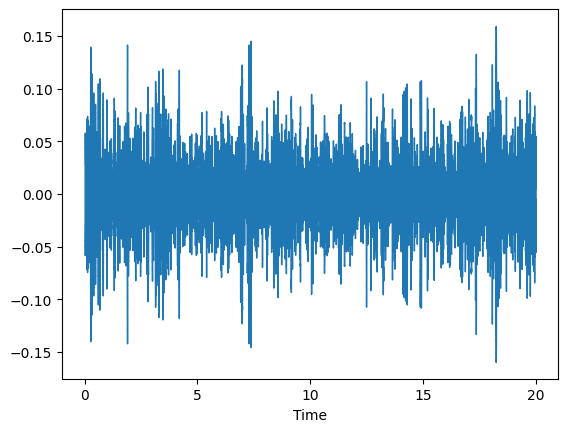

In [ ]:
librosa.display.waveshow(y, sr=sr);

In [ ]:
from linearFIR import filter_design, mfreqz
import scipy.signal as signal

250.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [1125.] Hz



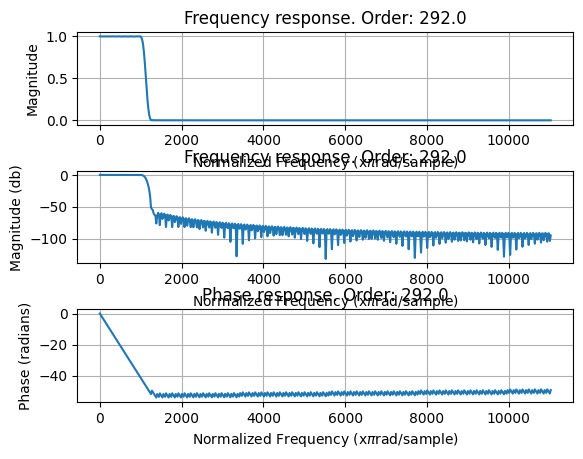

25.0
pop_eegfiltnew() - cutoff frequency(ies) (-6 dB): [87.5] Hz



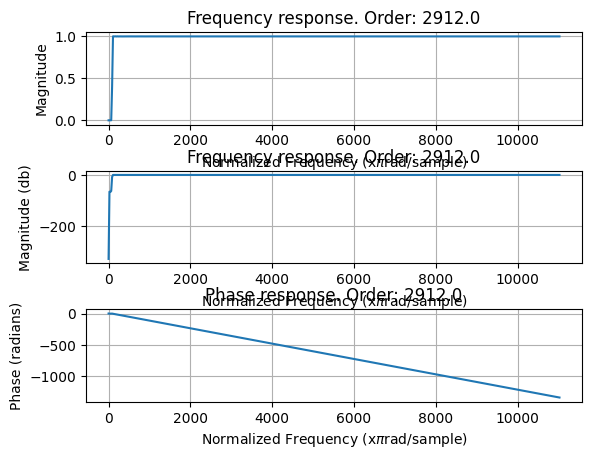

In [ ]:
fs = sr;
#design
order, lowpass = filter_design(fs, locutoff = 0, hicutoff = 1000, revfilt = 0);
#plot
mfreqz(lowpass,1,order, fs/2);

order, highpass = filter_design(fs, locutoff = 100, hicutoff = 0, revfilt = 1);
#plot
mfreqz(highpass,1,order, fs/2);

In [ ]:
y_hp = signal.filtfilt(highpass, 1, y);
y_bp = signal.filtfilt(lowpass, 1, y_hp);

In [ ]:
y_bp = np.asfortranarray(y_bp)
print(y_bp.shape)

(441000,)


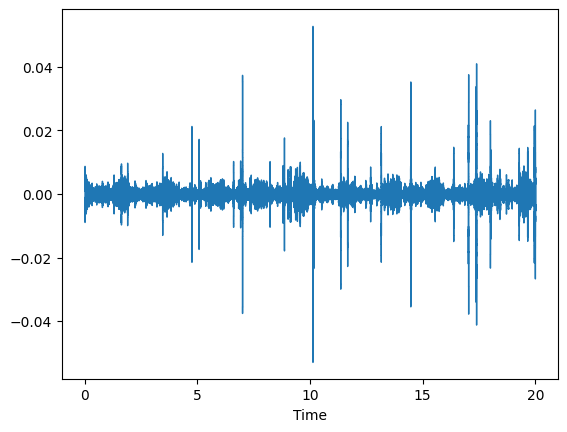

In [ ]:
librosa.display.waveshow(y_bp, sr=sr);

In [ ]:
def wnoisest(coeff):
    stdc = np.zeros((len(coeff),1));
    for i in range(0,len(coeff)):
        stdc[i] = (np.median(np.absolute(coeff[i])))/0.6745;
    return stdc;

def threshold(coeff):
    Num_samples = 0;
    for i in range(0,len(coeff)):
        Num_samples = Num_samples + coeff[i].shape[0];
    
    thr = np.sqrt(2*(np.log(Num_samples)))
    return thr

def wthresh(coeff):
    y   = list();
    s = wnoisest(coeff);
    print(s)
    thr = threshold(coeff)
    print(thr)
    for i in range(0,len(coeff)):
        y.append(np.multiply(coeff[i],np.abs(coeff[i])>(thr*s[i])));
    return thr,s,y;

LL = int(np.floor(np.log2(y_bp.shape[0])));

data_wavelet = pywt.wavedec( y_bp, 'db6', level=LL );
print(len(data_wavelet))

details = data_wavelet[1:]
print(len(details))

19
18


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  warnings.warn(


[[1.51822204e-01]
 [5.15130027e-02]
 [3.16739908e-02]
 [1.21027115e-02]
 [6.41084801e-06]
 [2.05823703e-06]
 [9.25683720e-06]
 [3.20858049e-05]
 [1.81492590e-04]
 [5.56411584e-04]
 [6.57020174e-03]
 [1.24714516e-02]
 [3.66621874e-03]
 [7.32597139e-04]
 [3.84954338e-04]
 [5.01452748e-05]
 [1.12922009e-06]
 [1.49802172e-08]]
5.098469751035389


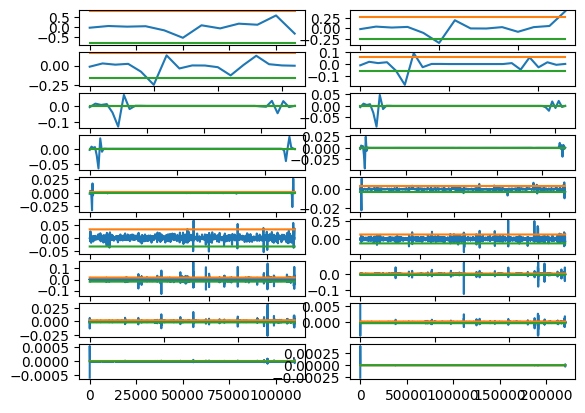

In [ ]:
thr, s, details_t = wthresh(details);

for i in range(len(details_t)):
  plt.subplot(9,2,i+1)
  plt.plot(details[i])
  plt.plot(thr*s[i]*np.ones((len(details[i]))))
  plt.plot(-1*thr*s[i]*np.ones((len(details[i]))))
plt.show()

In [ ]:
coeff = list()
coeff.append(data_wavelet[0])

for i in range(len(details_t)):
  coeff.append(details_t[i])

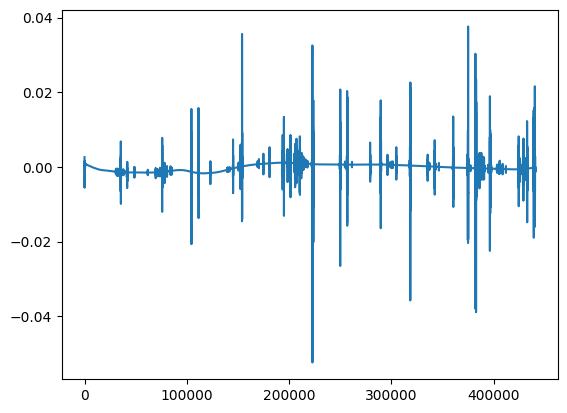

In [ ]:
x_rec = pywt.waverec( coeff, 'db6');
x_rec = x_rec[0:y_bp.shape[0]];

plt.plot(x_rec,label='Reconstruida')
plt.show()

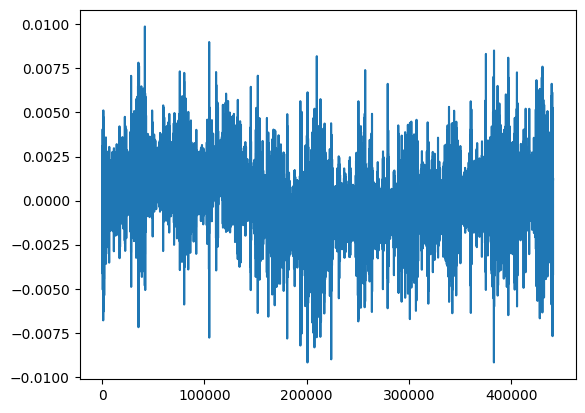

In [ ]:
x_filt = np.squeeze(y_bp - x_rec);
plt.plot(x_filt,label='Diferencia')
plt.show()

In [ ]:
import soundfile as sf

sf.write('stereo_file1.wav', x_filt, sr, 'PCM_24')

#librosa.output.write_wav('result.wav',x_filt,sr)

(1025,)


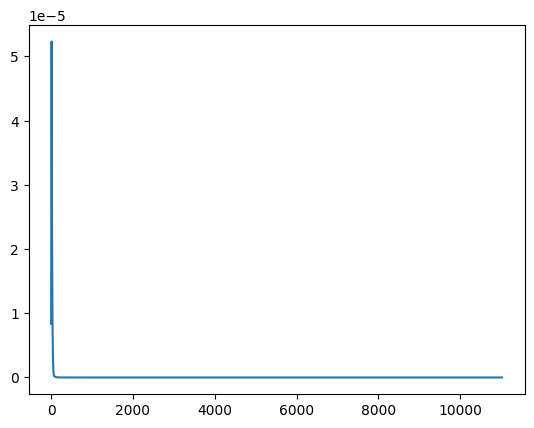

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(y,fs,'hamming', 2048, 1024, scaling='density');
print(f.shape)
plt.plot(f,Pxx)
plt.show()

(1025,)


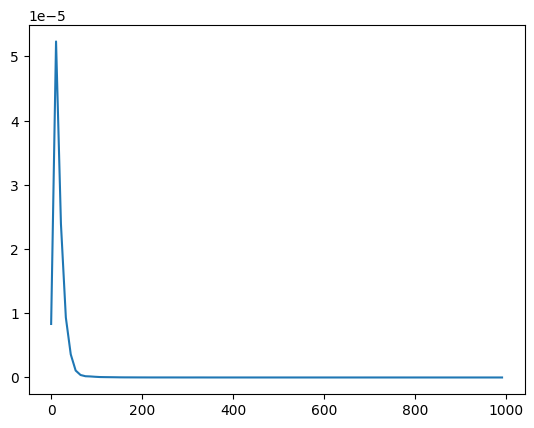

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(y,fs,'hamming', 2048, 1024, scaling='density');
print(f.shape)
plt.plot(f[f<1000],Pxx[f<1000])
plt.show()

(5121,)


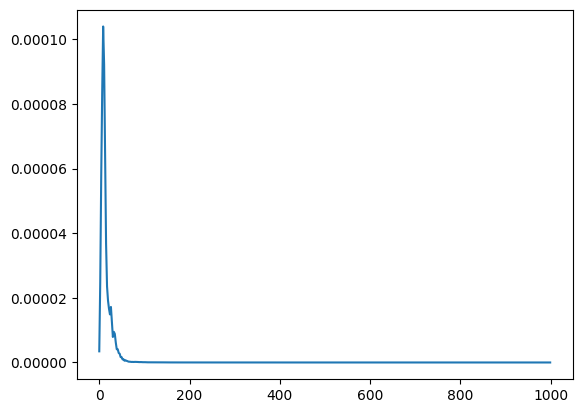

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(y,fs,'hamming', 2048*5, 1024*5, scaling='density');
print(f.shape)
plt.plot(f[f<1000],Pxx[f<1000])
plt.show()

(11026,)


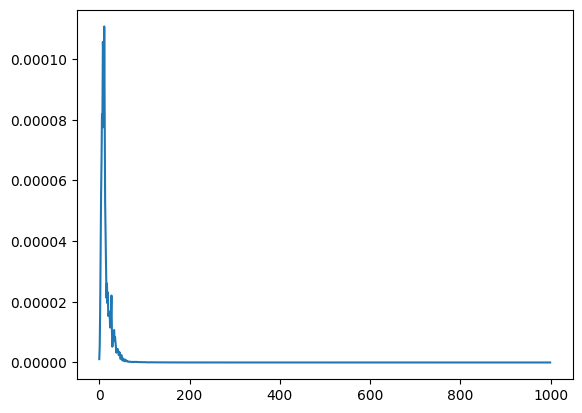

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(y,fs,'hamming', y.shape[0]*0.05, y.shape[0]*0.025, scaling='density');
print(f.shape)
plt.plot(f[f<1000],Pxx[f<1000])
plt.show()

(5513,)


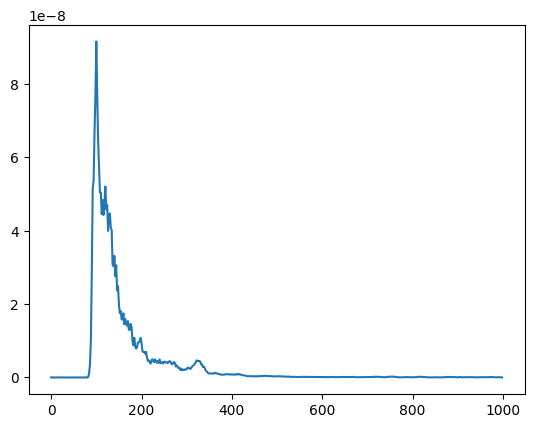

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(y_bp,fs,'hamming', y.shape[0]*0.025, y.shape[0]*0.0125, scaling='density');
print(f.shape)
plt.plot(f[f<1000],Pxx[f<1000])
plt.show()

In [ ]:
#%%analisis usando welch
import scipy.signal as signal;
#signal.welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None, 
#detrend='constant', return_onesided=True, scaling='density', axis=-1)
f, Pxx = signal.welch(x_filt,fs,'hamming', y.shape[0]*0.025, y.shape[0]*0.0125, scaling='density');
print(f.shape)
plt.plot(f[f<1000],Pxx[f<1000])
plt.show()

https://scipy-cookbook.readthedocs.io/items/FIRFilter.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firwin.html

In [ ]:
from numpy import absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz

#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sr / 2.0

# The cutoff frequency of the filter.
low_cutoff_hz = 1000
high_cutoff_hz = 100
N_hp = 2913
N_lp = 293

# Use firwin with a Kaiser window to create a lowpass FIR filter.
low_pass = firwin(N_lp, low_cutoff_hz/nyq_rate, window='hamming')

mfreqz(low_pass,1,order, nyq_rate);

high_pass = firwin(N_hp, high_cutoff_hz/nyq_rate, window='hamming',pass_zero='highpass')
mfreqz(high_pass,1,order, nyq_rate);


y_hp1 = signal.filtfilt(highpass, 1, y);
y_bp1 = signal.filtfilt(lowpass, 1, y_hp1);

y_bp1 = np.asfortranarray(y_bp1)
print(y_bp1.shape)

librosa.display.waveshow(y_bp1, sr=sr);

librosa.display.waveshow(y_bp1 - y_bp, sr=sr);